In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [2]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [5]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples" % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples


In [6]:
# Shuffle before split
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# Split train, valid and test set with each count
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [7]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # You must fit with train data only

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [8]:
n_epochs = 4000
batch_size = 256
print_interval = 100
early_stop = 100

In [9]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

optimizer = optim.Adam(model.parameters())

In [10]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [11]:
import time

train_history, valid_history = [], []

start = time.time()
for i in range(n_epochs):
    # Shuffle before mini-batch split
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index = indices)
    y_ = torch.index_select(y[0], dim=0, index = indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|

        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)

    # You need to declare to PYTORCH to stop build the computation graph
    with torch.no_grad():
        # You don't need to shuffle the validation set
        # Only split is needed.

        x_ = x[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0)

        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += loss

            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

        #Log each loss to plot after training is done.
        train_history += [train_loss]
        valid_history += [valid_loss]
    
        if(i + 1) % print_interval == 0:
            print('epoch %d/%d : train_loss=%.4e valid_loss=%.4e lowest_loss=%.4e elapsed_time=%.2fsec' % 
                  (i + 1, n_epochs, train_loss, valid_loss, lowest_loss, time.time() - start)
            )
            start = time.time()

        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i

            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print("There is no improvment during last %d epochs." % early_stop)
                break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model
model.load_state_dict(best_model)

epoch 100/4000 : train_loss=3.3388e-01 valid_loss=3.2223e-01 lowest_loss=3.2296e-01 elapsed_time=7.00sec
epoch 200/4000 : train_loss=3.0492e-01 valid_loss=2.9911e-01 lowest_loss=2.9540e-01 elapsed_time=7.61sec
epoch 300/4000 : train_loss=3.0098e-01 valid_loss=2.9646e-01 lowest_loss=2.9408e-01 elapsed_time=7.06sec
epoch 400/4000 : train_loss=2.9842e-01 valid_loss=2.9307e-01 lowest_loss=2.9274e-01 elapsed_time=6.92sec
epoch 500/4000 : train_loss=2.9547e-01 valid_loss=2.9243e-01 lowest_loss=2.9121e-01 elapsed_time=6.89sec
epoch 600/4000 : train_loss=2.9499e-01 valid_loss=2.9560e-01 lowest_loss=2.9103e-01 elapsed_time=6.73sec
epoch 700/4000 : train_loss=2.9343e-01 valid_loss=2.9309e-01 lowest_loss=2.9019e-01 elapsed_time=6.80sec
There is no improvment during last 100 epochs.
The best validation loss from epoch 632: 2.9019e-01


<All keys matched successfully>

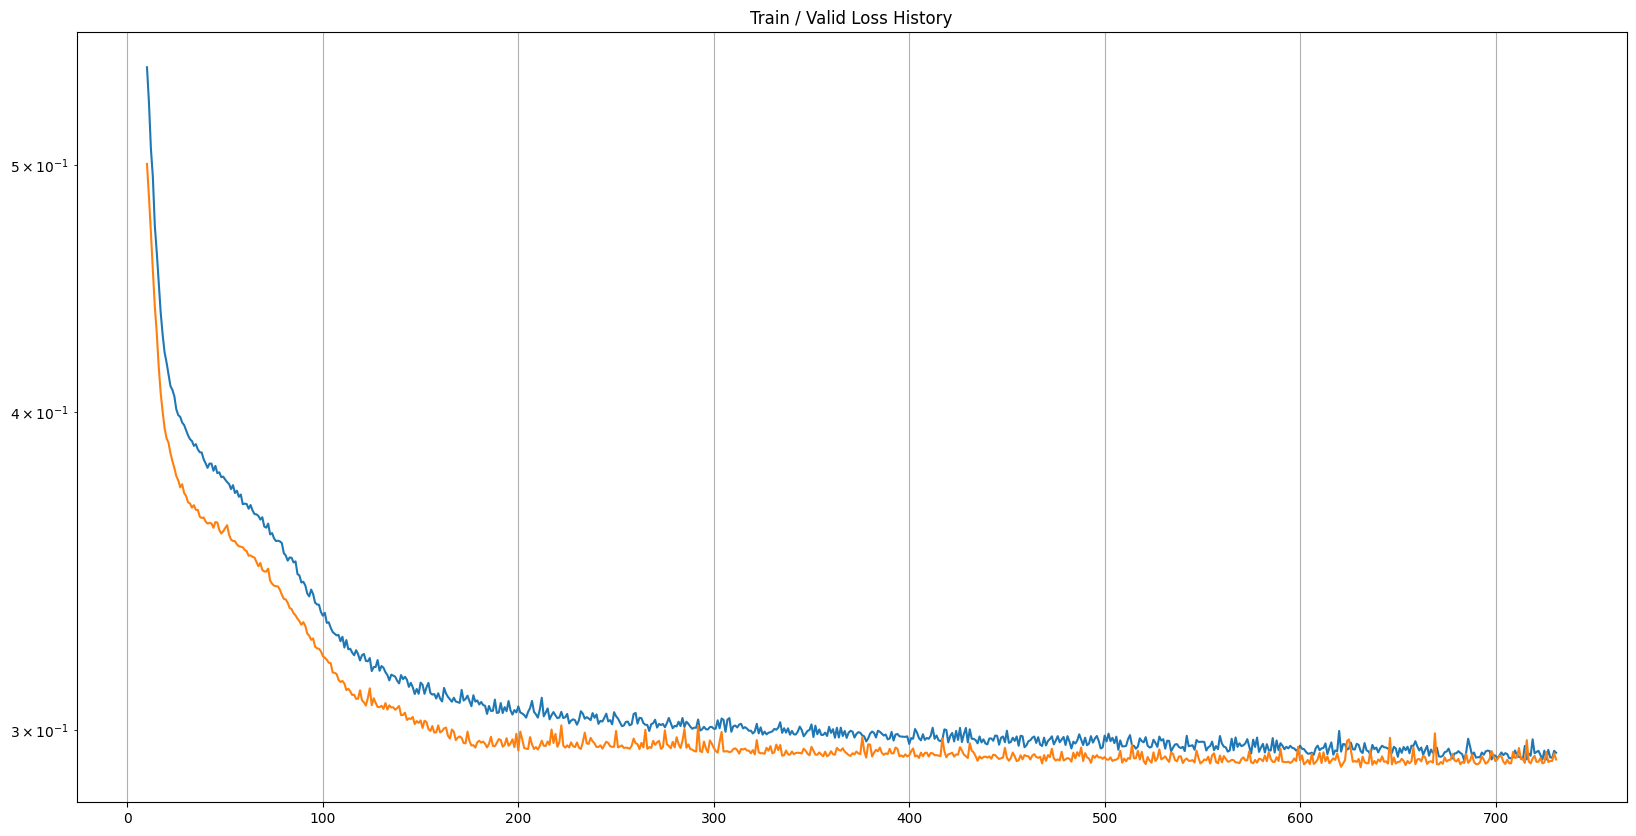

In [12]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train Loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid Loss')
plt.yscale('log')
plt.show()

In [13]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss : %.4e" % sorted_history[0][0])
print("Valid loss : %.4e" % sorted_history[0][1])
print("Test loss : %.4e" % test_loss)

Train loss : 2.9445e-01
Valid loss : 2.9019e-01
Test loss : 3.2049e-01


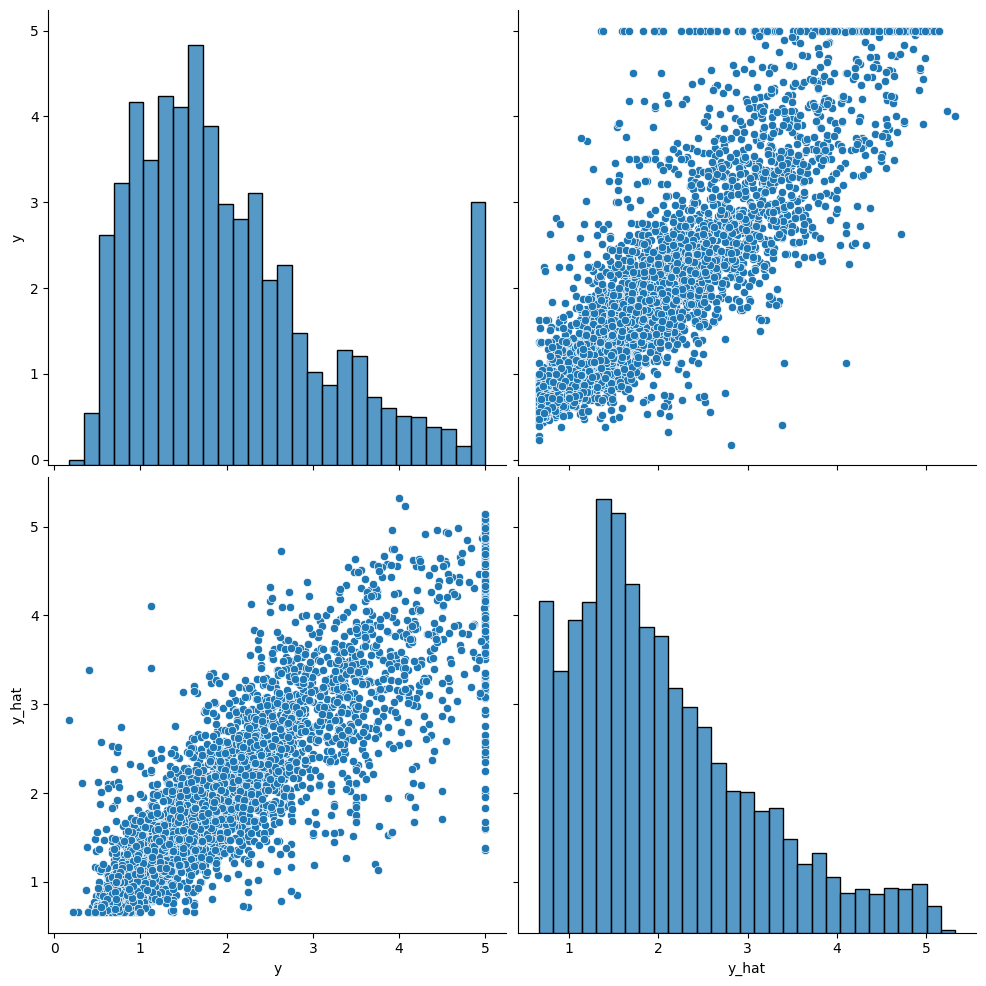

In [14]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()